In [17]:
import urllib.request
from numpy.lib.function_base import append  # lib that handles URLs
import pandas as pd
import re
import jieba
import jieba.analyse
import math
import matplotlib.pylab as plt

In [18]:
def init():
    target_url = "https://raw.githubusercontent.com/cjwu/cjwu.github.io/master/courses/nlp/hw1-dataset.txt"
    data = urllib.request.urlopen(target_url)

    with open('output.txt', 'a+') as f:
        for line in data:
            decoded_line = line.decode("utf-8")
            f.write(decoded_line)
    df = pd.read_fwf('./output.txt',header = None)
    df.columns = ['content']
    df.to_csv('./log.csv', encoding = 'utf-8',index = True)

In [19]:
class WordSegment:
    def __init__(self,texts,stop_words_path,dicts_path=""):
        self.jieba = jieba
        self.texts = texts
        self.dicts_path = dicts_path
        self.stop_words_path = stop_words_path
        
    def read_dictionary(self): 
        #讀取類別
        if self.dicts_path:
            for dic in self.dicts_path:
                self.jieba.load_userdict(dic)

    def read_stop_words(self):
        #讀取stopword
        self.stop_words = set()
        if stop_words_path:
            with open(stop_words_path,encoding = 'UTF-8') as file:
                self.stop_words = self.stop_words | set(map(str.strip,file.readlines()))
        
    def remove_stop_words(self):
        # 去除繁體中文以外的英文、數字、符號
        jieba.set_dictionary('./dict.txt.big')
        rule = re.compile(r"[^\u4e00-\u9fa5]")
        self.texts = [list(self.jieba.cut(rule.sub('', text))) for text in self.texts]
        for idx, speech in enumerate(self.texts):
            self.texts[idx] = ' '.join([word for word in speech if word.strip() not in self.stop_words])

In [20]:
def topic():
    topic = {}
    with open('log.csv', newline='') as f:
        contents = ""
        for i,line in enumerate(f.readlines()):
            if i==0:continue
            ind, content = line.split(",",1)
            contents = content
            topic[ind] = content
    return topic

In [21]:
#計算每行詞次數
def words_count():
    words_count = []
    for file in text_files:
        count = {}
        for word in file:
            if word in count:
                count[word] += 1
            else:
                count[word] = 1
        words_count.append(count)
    return words_count

In [22]:
#統計每個語詞的頻率(次數/全部語詞次數)tf
def words_frequency(words_count):
    words_frequency = []
    for word_count in words_count:
        all_count = sum(word_count.values()) #該行所有語詞的數量
        fre = {}
        for word,count in word_count.items():
            fre[word] = round(count/all_count,4)
        words_frequency.append(fre)
    return words_frequency

In [23]:
#idf 
#先取得包含該語詞的文件數量
#就是該語詞在幾個文件中"出現過"
def occurrences_of_word(words_count):
    all_words = []
    for word in words_count:
        all_words.extend(list(word.keys()))
    
    occurrences_of_word = {}
    for word in all_words:
        if word in occurrences_of_word:
            occurrences_of_word[word] += 1
        else:
            occurrences_of_word[word] = 1
    return occurrences_of_word



In [24]:
#文本數量/包含該語詞的數量
#就是行數量/該語詞在幾個文章中"出現過"
def inverse_document_frequency(words_count,occurrences_of_word):
    inverse_document_frequency = []     
    for word_count in words_count:
        invFre = {} 
        for word in word_count.keys():
            occurrences = occurrences_of_word[word]
            invFre[word] = math.log(round((len(words_count)/occurrences),4))
        inverse_document_frequency.append(invFre)
    return inverse_document_frequency

In [25]:
#tf*idf
def tf_idf(words_frequency,inverse_document_frequency):
    all_tf_idf = []
    for i,words in enumerate(words_frequency):
        tf_idf = {}
        for word,freq in words.items():
            tf_idf[word] = freq*inverse_document_frequency[i][word]
        all_tf_idf.append(tf_idf)

    super_dict = {}
    for d in all_tf_idf:
        for k, v in d.items():
            super_dict[k] = v
    return super_dict

In [26]:
init()
topic = topic()
jieba.setLogLevel(jieba.logging.INFO)
stop_words_path = './stop_words.txt'
ws = WordSegment(topic.values(),stop_words_path)
ws.read_stop_words()
ws.remove_stop_words()
text_files = [text.split(" ") for text in ws.texts]

In [27]:
words_count = words_count()
words_frequency = words_frequency(words_count)
occurrences_of_word = occurrences_of_word(words_count)

In [28]:
freq_word = []
for word, freq in occurrences_of_word.items():
    freq_word.append((word, freq))

freq_word.sort(key = lambda x: x[1], reverse = True) #反序排列，根據第二個參數
X = []
Y = []
i=0
print('高頻:')
for word, freq in freq_word[: 100]:
    print(i,word, (freq))
    X.append(i)
    Y.append(freq/len(words_count))
    i = i+1

高頻:
0 八卦 77914
1 有沒有 71819
2 什麼 63359
3 有 57271
4 你 55990
5 人 53761
6 在 48113
7 我 46730
8 會 41136
9 不 36862
10 要 36058
11 好 35172
12 跟 31913
13 台灣 31692
14 去 31004
15 為 30150
16 也 23840
17 說 23613
18 沒 22270
19 可以 22113
20 是不是 21383
21 怎麼 21121
22 到 19843
23 想 19067
24 肥宅 18277
25 吃 16820
26 現在 16798
27 看 16162
28 真的 15503
29 才 13859
30 他 13829
31 比較 13789
32 不會 13679
33 中國 13541
34 知道 13442
35 怎麼辦 12926
36 自己 12365
37 誰 12237
38 沒有 11922
39 多 11810
40 不是 11694
41 最 11319
42 還是 11129
43 就是 10752
44 用 10561
45 如果 10455
46 一個 10343
47 啦 10238
48 把 9946
49 一堆 9882
50 這樣 9844
51 上 9494
52 一樣 9469
53 阿 9149
54 做 8976
55 該 8969
56 買 8883
57 幹 8798
58 又 8741
59 覺得 8707
60 喔 8595
61 打 8513
62 到底 8377
63 怎樣 8229
64 應該 8206
65 能 8139
66 卦 8069
67 女生 8059
68 對 7818
69 大家 7777
70 時候 7689
71 那 7664
72 喜歡 7659
73 後 7597
74 不要 7494
75 有人 7398
76 日本 7289
77 很多 7274
78 讓 7202
79 叫 7021
80 美國 6834
81 中 6645
82 大 6536
83 這 6534
84 小 6493
85 再 6466
86 比 6458
87 哪 6438
88 哪個 6429
89 幹嘛 6289
90 因為 6273
91 呢

In [29]:
inverse_document_frequency = inverse_document_frequency(words_count,occurrences_of_word)
super_dict = tf_idf(words_frequency,inverse_document_frequency)  

<BarContainer object of 100 artists>

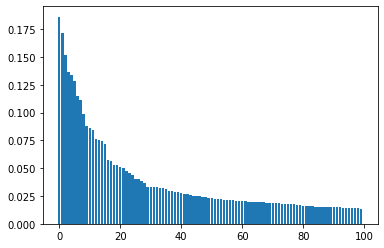

In [30]:
plt.bar(X,Y)  

In [31]:
L = sorted(super_dict.items(),key=lambda item:item[1],reverse=True)
X1 = []
Y1 = []
i=0
print('weight hight:')
for word, freq in L[:100]:
    X1.append(i)
    Y1.append(freq)
    print(i,word, freq)
    i = i+1

weight hight:
0 咪姆宅 12.943719848366
1 收悉 12.943719848366
2 戊戌 12.943719848366
3 吉吉吉覆吉吉 12.943719848366
4 曹長 12.943719848366
5 圖咧文 12.943719848366
6 喇喇喇喇喇喇喇 12.943719848366
7 愛玩耍 12.943719848366
8 偽鈔 12.943719848366
9 角速度 12.943719848366
10 推三小三小 12.943719848366
11 斯洛伐克 12.250572667806054
12 泰拉 12.250572667806054
13 柔珠 11.557425487246109
14 搖起來 11.151960378659707
15 岡本 10.864278306686163
16 反田 10.3549758786928
17 海闊天空 10.304662517794265
18 簽拉 9.625274945095216
19  9.072518841284012
20 輝輝輝 8.629578022905612
21 哈連雞 8.629578022905612
22 皮豆 8.321517490514502
23 甲殼蟲樂隊 6.471859924183
24 兇宅夜 6.471859924183
25 歌太早 6.471859924183
26 阿輝 6.471859924183
27 韋廷 6.471859924183
28 海灣 6.471859924183
29 電和聯電 6.471859924183
30 帥之形 6.471859924183
31 糖三淆 6.471859924183
32 鼠鼠王 6.471859924183
33 董滋 6.471859924183
34 嘻三小糙 6.471859924183
35 動漫卡通 6.471859924183
36 羽彩 6.471859924183
37 嘴破還 6.471859924183
38 估摸 6.471859924183
39 問鄒智全 6.471859924183
40 公三小喇蛤 6.471859924183
41 天鬧板 6.471859924183
42 傘肥刀 6.47185992418

<BarContainer object of 100 artists>

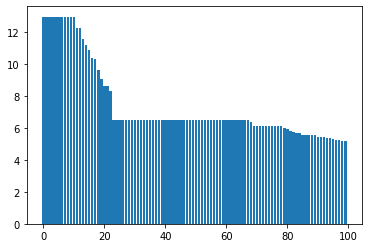

In [32]:
plt.bar(X1,Y1)